In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [2]:
import numpy as np
import pandas as pd
import umap
from sklearn.datasets import make_classification

np.random.seed(seed=42) 

In [111]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4], "C":[1,10]},
    { "max_iter":[10000000], "loss":["squared_hinge", "hinge"], "tol":[1e-4], "C":[1,10,30]}
]

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC(**{'C': 1, "loss":"hinge", 'max_iter': 10000000, 'penalty': 'l2', 'tol': 0.0001}))
])

def runSVM(X,y, X_valid,y_valid):
    
    clf_grid = Pipeline([
        ("scaler", StandardScaler()),
        ("SVMGrid",GridSearchCV(LinearSVC(), param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=8))
    ])
    
    clf_grid.fit(X, y)
    grid = clf_grid.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    svm_clf.fit(X, y)
    print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

    _score = cross_val_score(svm_clf, X=X, y=y, cv=10)
    print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    return svm_clf, grid.best_params_

In [142]:
X,y = make_classification(n_samples=10000, n_classes=3, weights=[0.5,0.25,0.25], n_features=10,
                          n_informative=5, n_redundant=5, class_sep=0.7, n_clusters_per_class=1,
                          hypercube=True, shuffle=False, random_state=42)
# X,y = make_classification(n_samples=3000, n_classes=3, n_informative=3, class_sep=1, n_clusters_per_class=1, hypercube=False, shuffle=False, random_state=42)
X.shape

(10000, 10)

In [87]:
X[:,:3].shape

(10000, 3)

In [221]:
reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=100,
                    min_dist=1)
embedding = reducer.fit_transform(X)

# embedding=X[:, :3]

/home/smaug/anaconda3/envs/condatensor/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/condatensor/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^




In [222]:
emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=2,
        color=y,
        colorscale="Viridis",
        showscale=True,
        opacity=0.8
    ),
    text=y
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5'
)


pltdata=[emb3d]

fig = go.Figure(data=pltdata, layout=layout)
iplot(fig, filename='lrp-3d-heart.html')

In [194]:
from helper import split_valid, plot_confusion_matrix
from sklearn.metrics import classification_report

data = pd.DataFrame(X)
labels = pd.Series(y)

X_train, y_train, X_valid, y_valid = split_valid(data, labels, valid_size=0.5)

In [195]:
y_valid.value_counts()

0    2494
2    1253
1    1253
dtype: int64

In [196]:
%time clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(X_valid, y_valid)))

CPU times: user 62.1 ms, sys: 218 µs, total: 62.3 ms
Wall time: 61.1 ms
SVM Test Accuracy: 0.765


In [197]:
# original_svm, orig_best_params = runSVM(X_train, y_train, X_valid, y_valid)
original_svm = clf

In [198]:
y_pred = original_svm.predict(X_valid)
target_names = np.array(["A","B","C"])
print(classification_report(y_valid.values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           A       0.79      0.92      0.85      2494
           B       0.74      0.76      0.75      1253
           C       0.72      0.47      0.57      1253

    accuracy                           0.77      5000
   macro avg       0.75      0.71      0.72      5000
weighted avg       0.76      0.77      0.75      5000



Confusion matrix, without normalization
[[0.91860465 0.01684042 0.06455493]
 [0.18914605 0.75977654 0.05107741]
 [0.30407023 0.23064645 0.46528332]]
Overall Accuracy: 0.7652


(<matplotlib.axes._subplots.AxesSubplot at 0x7f30d9ec8630>,
 array([[2291,   42,  161],
        [ 237,  952,   64],
        [ 381,  289,  583]]))

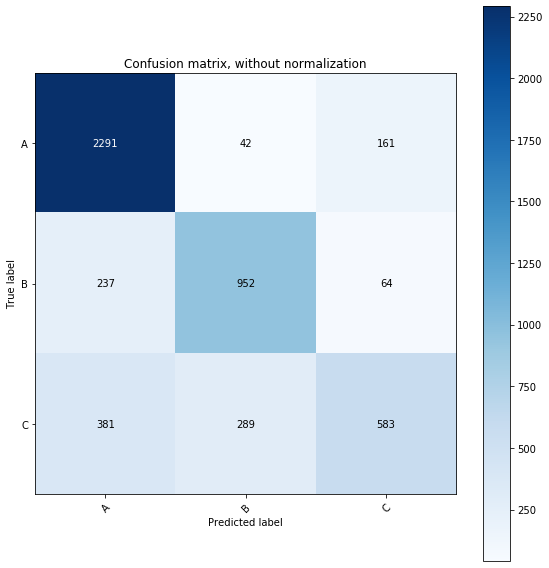

In [199]:
plot_confusion_matrix(y_valid.values, y_pred.astype(int), target_names)

In [205]:
new_data = pd.DataFrame(columns=data.columns)
new_labels = pd.Series()

skip_class = 0
# class_size = labels.value_counts()[skip_class]

# for labl in range(3):
#     _labels = labels[ labels == labl]
    
#     size = class_size #//2
# #     if labl == skip_class: size *=2 # To balance final binary classes 
    
#     rand_selected = _labels.sample(n=size, replace=False, random_state=42).index
#     _data = data.reindex(rand_selected)
#     _labels = _labels.reindex(rand_selected)
    
#     new_data = new_data.append(_data)
#     new_labels = new_labels.append(_labels)


new_data = data.copy()
new_labels = labels.copy()

new_labels[new_labels == skip_class] = -1

new_labels[new_labels != -1] = 1

# skip_class is now control
new_labels[new_labels == -1] = 0

print(new_data.shape)
new_data.head()

(10000, 10)


,0,1,2,3,4,5,6,7,8,9
0,-0.298819,-0.207636,0.336740,-0.241800,0.511053,-0.169162,0.115048,-1.010166,0.322902,0.191744
1,3.032506,2.915460,-2.028930,-3.457300,-1.082616,1.590476,-5.863924,0.670564,-2.421442,-4.603312
2,2.896556,0.639597,-1.310574,-1.355019,0.830541,-0.418640,-2.133277,-1.151617,-1.033043,-2.155477
3,-0.011948,0.154973,1.231940,-0.171779,0.768823,-1.173593,-0.750644,-1.665942,-0.131173,-0.064675
4,5.107862,-1.077666,-1.784118,-1.287695,2.608005,-1.811146,-1.072125,-3.929656,-1.482275,-2.297513


In [206]:
X_train, y_train, X_valid, y_valid = split_valid(new_data, new_labels, valid_size=0.5)
X_train.index

Int64Index([2010, 3196, 2113, 8463, 7027, 8377, 5051, 8721, 3776, 2771,
            ...
            7499, 9351, 6298, 3063, 5317, 6911, 2586, 9961, 4615, 5736],
           dtype='int64', length=5000)

In [207]:
%time clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(X_valid, y_valid)))

CPU times: user 24 ms, sys: 508 µs, total: 24.5 ms
Wall time: 23.5 ms
SVM Test Accuracy: 0.839


In [208]:
# original_svm, orig_best_params = runSVM(X_train, y_train, X_valid, y_valid)

In [209]:
original_svm = clf
y_pred = original_svm.predict(X_valid)
target_names = np.array(["A","BC"])
print(classification_report(y_valid.values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           A       0.81      0.88      0.84      2494
          BC       0.87      0.80      0.83      2506

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



Confusion matrix, without normalization
[[0.87650361 0.12349639]
 [0.19912211 0.80087789]]
Overall Accuracy: 0.8386


(<matplotlib.axes._subplots.AxesSubplot at 0x7f30d9c9d668>,
 array([[2186,  308],
        [ 499, 2007]]))

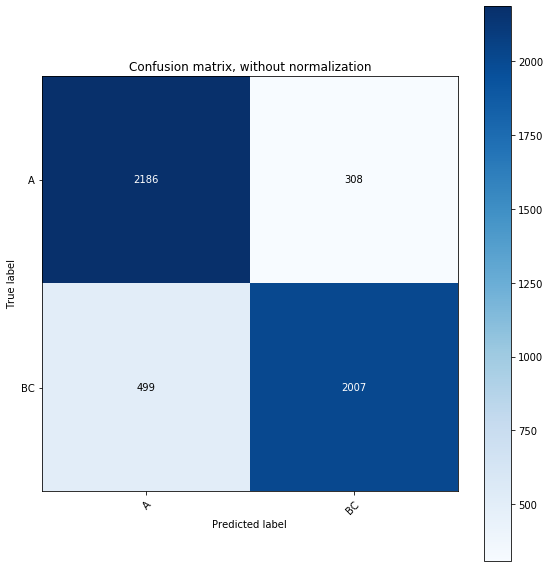

In [210]:
plot_confusion_matrix(y_valid.values, y_pred.astype(int), target_names)

# Looking at subclusters separated

In [211]:
X_train, y_train, X_valid, y_valid = split_valid(data, labels, valid_size=0.5)

In [212]:
from sklearn.utils.multiclass import unique_labels

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC(**{'C': 1, 'max_iter': 10000000, 'loss': 'hinge', 'tol': 0.0001}))
])


from imblearn.over_sampling import SMOTE

def runSVMAnalysis(skip_class, classes=np.array(["A","B","C"])):
    
    _X = X_train[y_train != skip_class]
    _y = y_train[y_train != skip_class]
    
    bi_train, bi_y_train = SMOTE(random_state=42).fit_resample(_X,np.ravel(_y))
    
    bi_valid = X_valid[y_valid != skip_class]
    bi_y_valid = y_valid[y_valid != skip_class]
    
    %time clf.fit(bi_train, bi_y_train)
    print("SVM Test Accuracy: {:0.3f}".format(clf.score(bi_valid, bi_y_valid)))

#     bi_svm, bi_best_params = runSVM(bi_train, bi_y_train, bi_valid, bi_y_valid)
    bi_svm = clf
    
    y_pred =  bi_svm.predict(bi_valid)
    correct_ = bi_y_valid[y_pred == bi_y_valid]

    # Only use the labels that appear in the data
    print(unique_labels(bi_y_valid, y_pred))
    target_names = classes[unique_labels(bi_y_valid, y_pred)]
    print(classification_report(bi_y_valid.values, y_pred, target_names=target_names))

    plot_confusion_matrix(bi_y_valid.values, y_pred.astype(int), classes)
    
    return correct_

## A vs B

CPU times: user 23.2 ms, sys: 420 µs, total: 23.7 ms
Wall time: 23.7 ms
SVM Test Accuracy: 0.931
[0 1]
              precision    recall  f1-score   support

           A       0.93      0.97      0.95      2494
           B       0.93      0.86      0.89      1253

    accuracy                           0.93      3747
   macro avg       0.93      0.91      0.92      3747
weighted avg       0.93      0.93      0.93      3747

Confusion matrix, without normalization
[[0.96631917 0.03368083]
 [0.13886672 0.86113328]]
Overall Accuracy: 0.9311


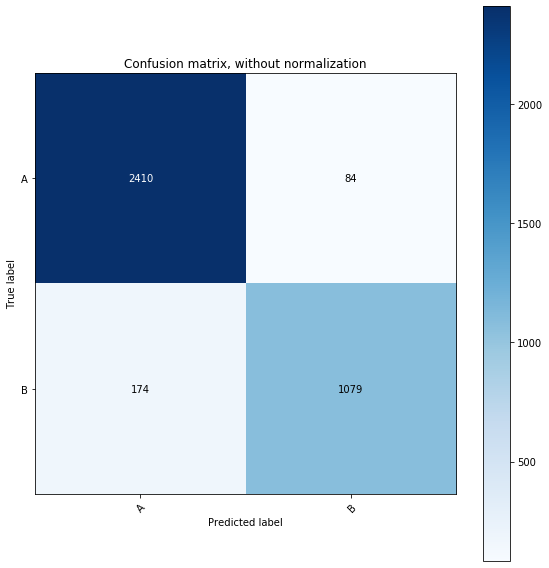

In [213]:
correct_AB = runSVMAnalysis(skip_class=2)

## A vs C

CPU times: user 20.7 ms, sys: 80 µs, total: 20.8 ms
Wall time: 20.8 ms
SVM Test Accuracy: 0.800
[0 2]
              precision    recall  f1-score   support

           A       0.93      0.75      0.83      2494
           C       0.65      0.89      0.75      1253

    accuracy                           0.80      3747
   macro avg       0.79      0.82      0.79      3747
weighted avg       0.84      0.80      0.81      3747

Confusion matrix, without normalization
[[0.7542101  0.2457899 ]
 [0.10853951 0.89146049]]
Overall Accuracy: 0.8001


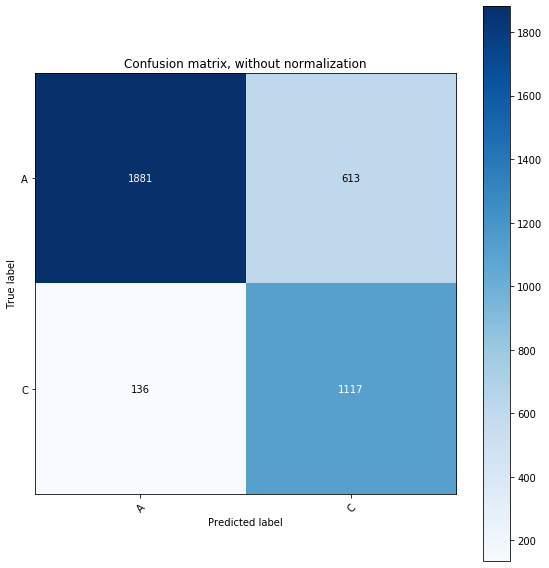

In [214]:
correct_AC = runSVMAnalysis(skip_class=1)

In [218]:
print("BC Accuracy:",len(correct_AB[correct_AB == 1]) + len(correct_AC[correct_AC == 2]))

BC Accuracy: 2196


In [219]:
(2196-2007)/2007

0.09417040358744394

## B vs C

CPU times: user 9.6 ms, sys: 0 ns, total: 9.6 ms
Wall time: 9.61 ms
SVM Test Accuracy: 0.856
[1 2]
              precision    recall  f1-score   support

           B       0.82      0.91      0.86      1253
           C       0.90      0.80      0.85      1253

    accuracy                           0.86      2506
   macro avg       0.86      0.86      0.86      2506
weighted avg       0.86      0.86      0.86      2506

Confusion matrix, without normalization
[[0.90901836 0.09098164]
 [0.19792498 0.80207502]]
Overall Accuracy: 0.8555


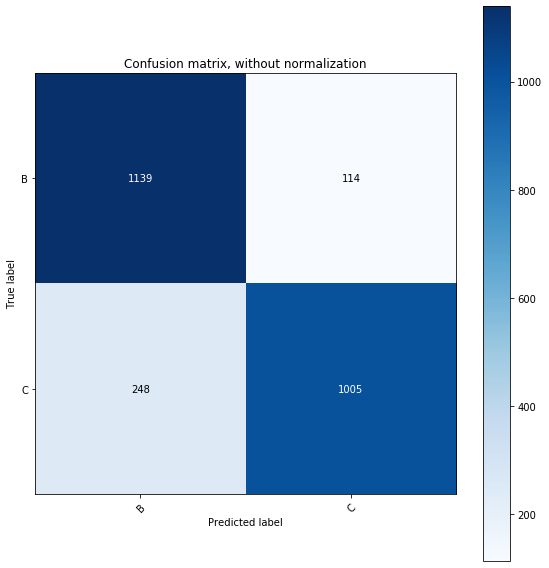

In [215]:
correct_BC = runSVMAnalysis(skip_class=0)

## Looking at final per-class accuracies

In [171]:
y_valid.value_counts()

0    2494
2    1253
1    1253
dtype: int64

In [220]:
A_idxs_1 = set(correct_AC[correct_AC == 0].index)
A_idxs_2 = set(correct_AB[correct_AB == 0].index)

A_total = A_idxs_1.union(A_idxs_2)
print("Number of A samples predicted:", len(A_total))
print("Ratio:", len(A_total)/y_valid.value_counts()[0])

Number of A samples predicted: 2438
Ratio: 0.9775461106655974


In [173]:
B_idxs_1 = set(correct_BC[correct_BC == 1].index)
B_idxs_2 = set(correct_AB[correct_AB == 1].index)

B_total = B_idxs_1.union(B_idxs_2)
print("Number of B samples predicted:", len(B_total))
print("Ratio:", len(B_total)/y_valid.value_counts()[1])

Number of B samples predicted: 1193
Ratio: 0.9521149241819633


In [174]:
# B_total - B_idxs_1

In [175]:
C_idxs_1 = set(correct_BC[correct_BC == 2].index)
C_idxs_2 = set(correct_AC[correct_AC == 2].index)

C_total = C_idxs_1.union(C_idxs_2)
print("Number of C samples predicted:", len(C_total))
print("Ratio:", len(C_total)/y_valid.value_counts()[2])

Number of C samples predicted: 1179
Ratio: 0.9409417398244214


In [176]:
# C_total - C_idxs_2

## By looking at these observations, we have evidence that the dataset will perform well for our analysis
## The initial binary classification should be A vs (B v C)
## The results above show us that A vs C and B vs C should both perform better

In [177]:
labels.value_counts().min()

2505

# Important dims

In [184]:
# data[range(5)]

In [185]:
new_data = data[range(5)].copy()
new_labels = labels.copy()

new_labels[new_labels == skip_class] = -1

new_labels[new_labels != -1] = 1

# skip_class is now control
new_labels[new_labels == -1] = 0

print(new_data.shape)
new_data.head()

(10000, 5)


,0,1,2,3,4
0,-0.298819,-0.207636,0.336740,-0.241800,0.511053
1,3.032506,2.915460,-2.028930,-3.457300,-1.082616
2,2.896556,0.639597,-1.310574,-1.355019,0.830541
3,-0.011948,0.154973,1.231940,-0.171779,0.768823
4,5.107862,-1.077666,-1.784118,-1.287695,2.608005


In [186]:
X_train, y_train, X_valid, y_valid = split_valid(new_data, new_labels, valid_size=0.5)
X_train.index

Int64Index([2010, 3196, 2113, 8463, 7027, 8377, 5051, 8721, 3776, 2771,
            ...
            7499, 9351, 6298, 3063, 5317, 6911, 2586, 9961, 4615, 5736],
           dtype='int64', length=5000)

In [187]:
%time clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(X_valid, y_valid)))

CPU times: user 20.3 ms, sys: 21 µs, total: 20.3 ms
Wall time: 19.3 ms
SVM Test Accuracy: 0.838


In [188]:
# original_svm, orig_best_params = runSVM(X_train, y_train, X_valid, y_valid)

In [189]:
original_svm = clf
y_pred = original_svm.predict(X_valid)
target_names = np.array(["A","BC"])
print(classification_report(y_valid.values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           A       0.81      0.87      0.84      2494
          BC       0.87      0.80      0.83      2506

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



Confusion matrix, without normalization
[[0.8744988  0.1255012 ]
 [0.19792498 0.80207502]]
Overall Accuracy: 0.8382


(<matplotlib.axes._subplots.AxesSubplot at 0x7f30d32ba2e8>,
 array([[2181,  313],
        [ 496, 2010]]))

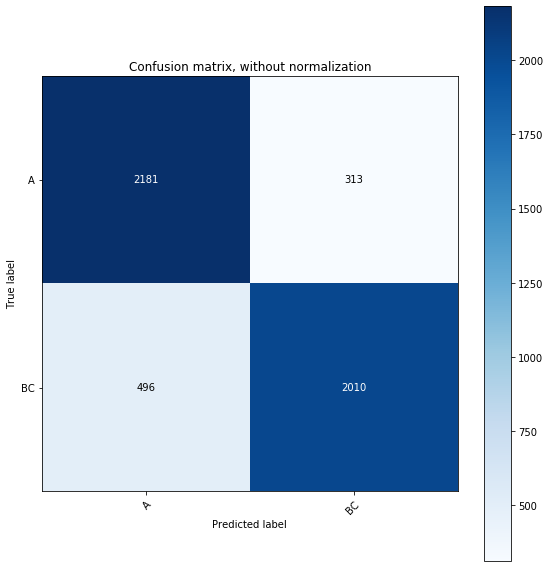

In [190]:
plot_confusion_matrix(y_valid.values, y_pred.astype(int), target_names)

CPU times: user 17.8 ms, sys: 0 ns, total: 17.8 ms
Wall time: 17.1 ms
SVM Test Accuracy: 0.838
[0 1]
              precision    recall  f1-score   support

           A       0.81      0.87      0.84      2494
           B       0.87      0.80      0.83      2506

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000

Confusion matrix, without normalization
[[0.8744988  0.1255012 ]
 [0.19792498 0.80207502]]
Overall Accuracy: 0.8382


2949    0
9565    1
7662    1
147     0
6929    1
       ..
8193    1
2707    0
2393    0
3460    0
5827    1
Length: 4191, dtype: int64

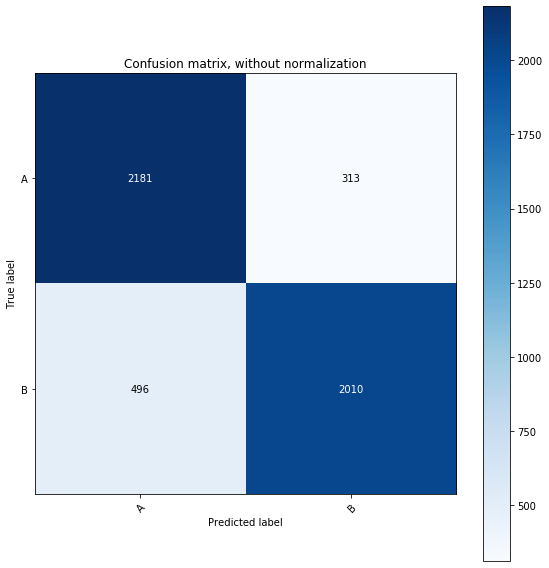

In [191]:
runSVMAnalysis(skip_class=2)

In [130]:
runSVMAnalysis(skip_class=1)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

IndexError: index 1 is out of bounds for axis 0 with size 1